# Nonparametric Regression between Meteorology Data and Park Visitations
a. stein
3/16/2022

This notebook builds off of `park_met_relations.ipynb` where compiling meteorology timeseries for each park was developed and parametric regression (that is mostly non-applicable due to the non-normal nature of the visitation data) was explored. Here I build off of that to use better suited statistical tools for non-normal distributions, aka non-parametric regression and tests.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import pandas as pd
import geopandas as gpd
import contextily as cx
from tqdm.autonotebook import tqdm

import rioxarray
from shapely.geometry import mapping

import sys
sys.path.append('../../')
import sedi.wrangle as wrangle

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


Load in data

In [11]:
park_path = '/pool0/home/steinadi/data/drought/drought_impact/data/socio-econ'
nat_park_visits = xr.open_dataset(f'{park_path}/national_parks_or_wa.nc')

In [3]:
met_path = '/pool0/home/steinadi/data/drought/drought_impact/data/met'
nat_park_met = xr.open_dataset(f'{met_path}/waor_natpark_monthly_met_1979_2021.nc')

I think the first thing I need to do is learn how to do some filtering on nonparametric data ... something more sophisticated than just setting a min/max.

Currently I'm doing a bunch of reading from the AMATH Data Book. Stay tuned folks.

OH. THIS IS A COMPLEX SYSTEM. I SHOULD TREAT IT AS SUCH AND USE THE MATH I KNOW WITH IT!!!

First I am going to try some decomposition on the park data.

In [8]:
from scipy.linalg import svd

In [52]:
# M dimension is time, N dimension is space (parks)

[U, S, V] = svd(nat_park_visits['Day Visits'].dropna(dim='time').values, full_matrices=False)

Check Shapes

In [57]:
np.shape(U)

(372, 11)

In [58]:
np.shape(S)

(11,)

In [59]:
np.shape(V)

(11, 11)

Oh, I think that S is only one dimension because the spatial dimension is only compose of which park, not lat-lon of each park

Lets' see if we get anything interesting ...

EOF 1 variance explained: 0.7168198446735139
EOF 2 variance explained: 0.08371393361100256


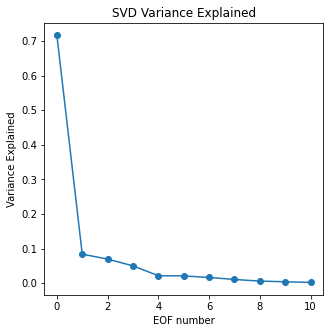

In [75]:
variance_explained = S / np.sum(S)
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(variance_explained, '-o')
ax.set_xlabel('EOF number')
ax.set_ylabel('Variance Explained')
ax.set_title('SVD Variance Explained')
print(f'EOF 1 variance explained: {variance_explained[0]}')
print(f'EOF 2 variance explained: {variance_explained[1]}')

So the first EOF explains the majority of the variance ... then steeply drops off after that.

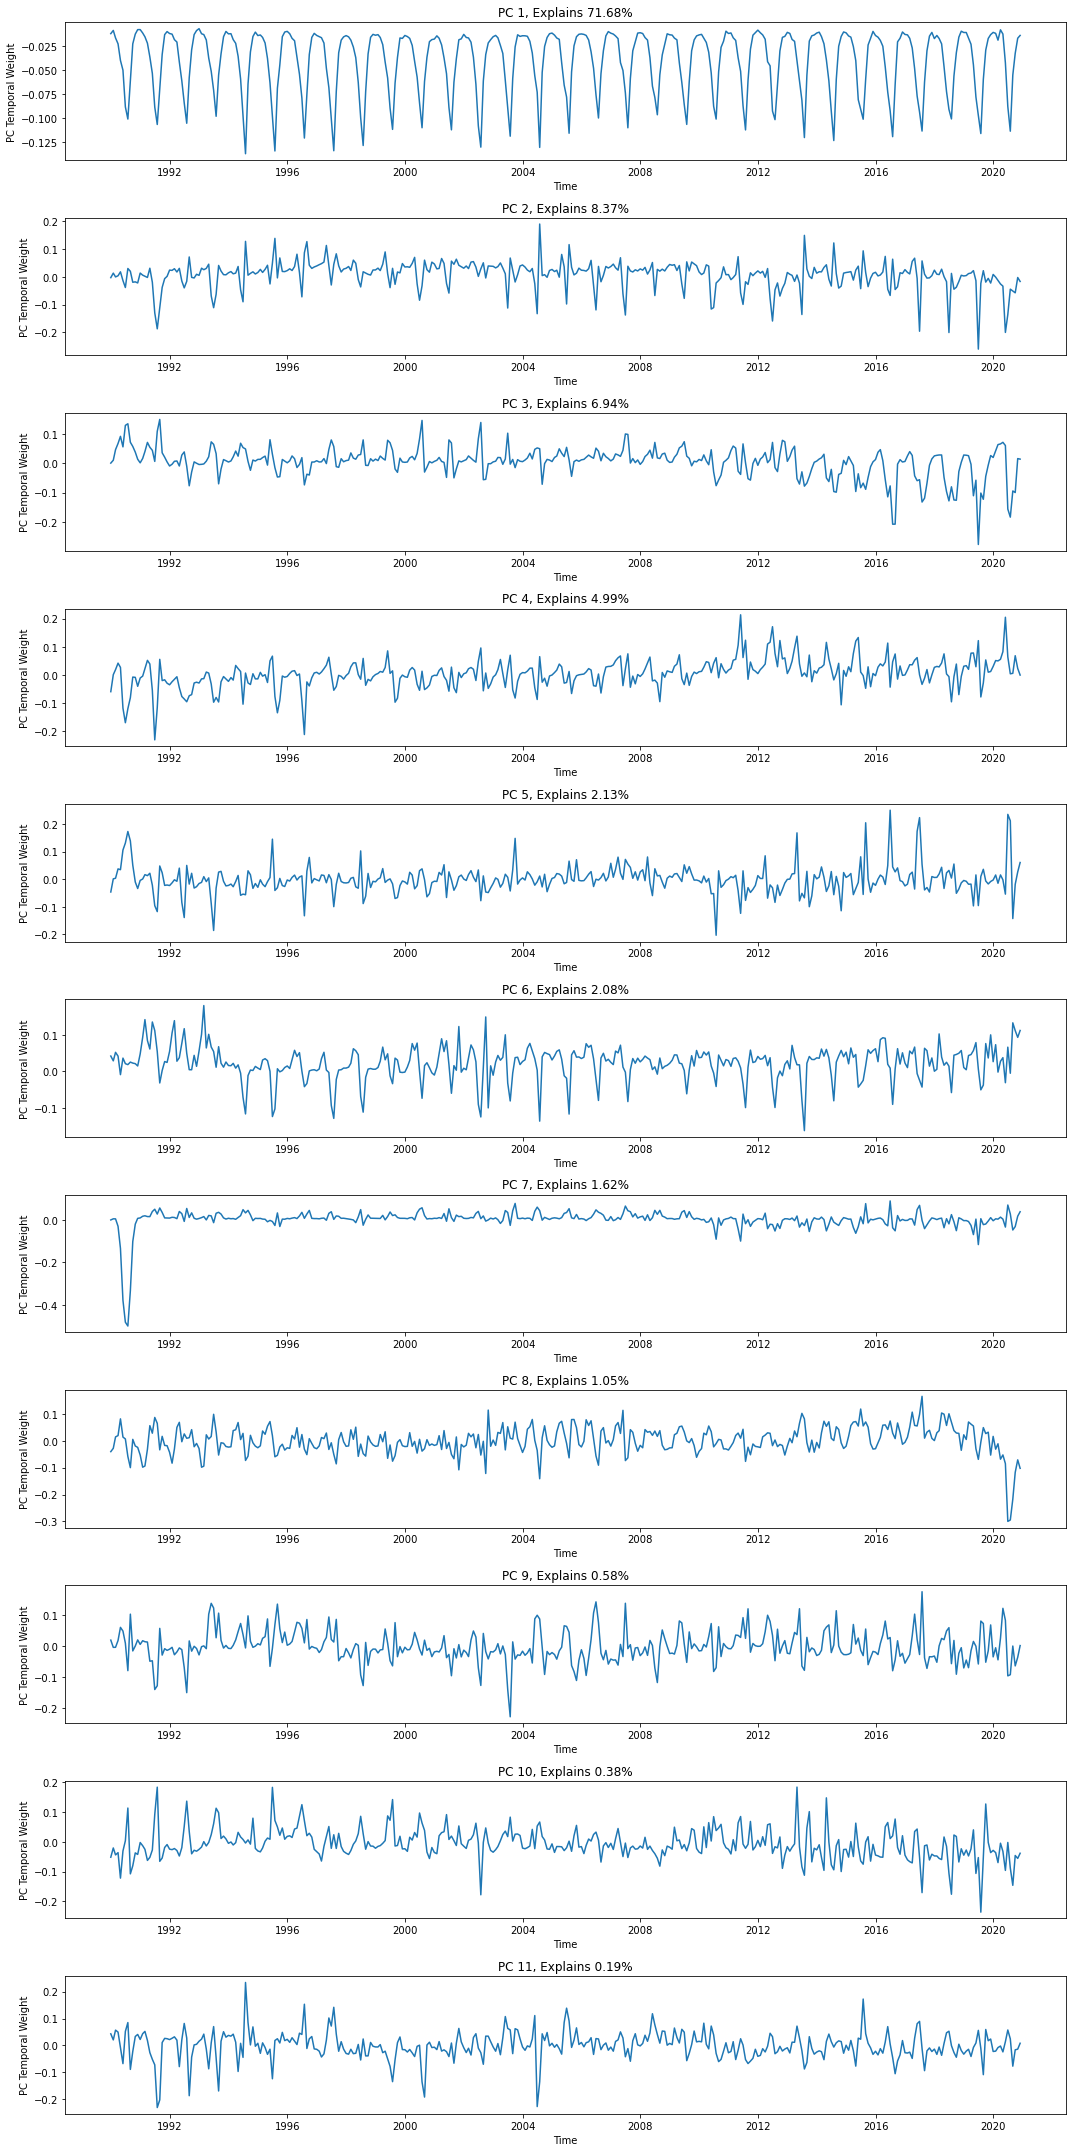

In [82]:
fig, axs = plt.subplots(11, 1, figsize=(15,30))

times = nat_park_visits['Day Visits'].dropna(dim='time')['time'].values

# to pull temporal weights, I want to move along the columns

for i, ax in zip(np.arange(0,11,1), axs.ravel()):
    ax.plot(times, U[:,i])
    ax.set_xlabel('Time')
    ax.set_ylabel('PC Temporal Weight')
    ax.set_title(f'PC {i+1}, Explains {variance_explained[i]*100:.2f}%')

plt.tight_layout()

I want to zoom in on that first one and just see if it's a yearly cycle ...

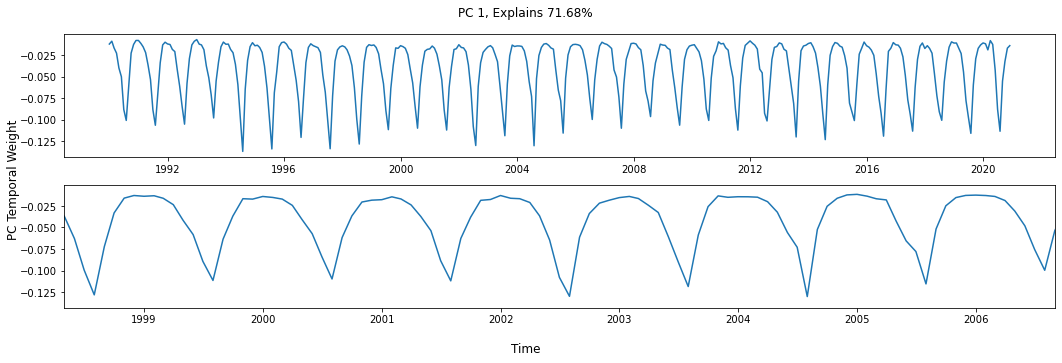

In [85]:
fig, axs = plt.subplots(2, 1, figsize=(15,5))

times = nat_park_visits['Day Visits'].dropna(dim='time')['time'].values

# pull out first one
i = 0

ax=axs.ravel()
ax[0].plot(times, U[:,i])
ax[1].plot(times, U[:,i])
ax[1].set_xlim(times[100], times[200])

fig.supxlabel('Time')
fig.supylabel('PC Temporal Weight')


fig.suptitle(f'PC {i+1}, Explains {variance_explained[i]*100:.2f}%')

plt.tight_layout()

Yup, that's just a seasonal cycle. Cool, glad we verified that. Guess that's reassuring that that does show up ... would be concerning if not.

Anything interesting going on spatially?

In [105]:
nat_park_gdf = gpd.read_file('../../data/geometry/pw_nps_select_geo.geojson')

In [119]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)
wa_gdf = states_gdf[(states_gdf.NAME=='Washington')]
or_gdf = states_gdf[(states_gdf.NAME=='Oregon')]

Text(0.5, 1.0, 'EOF 1')

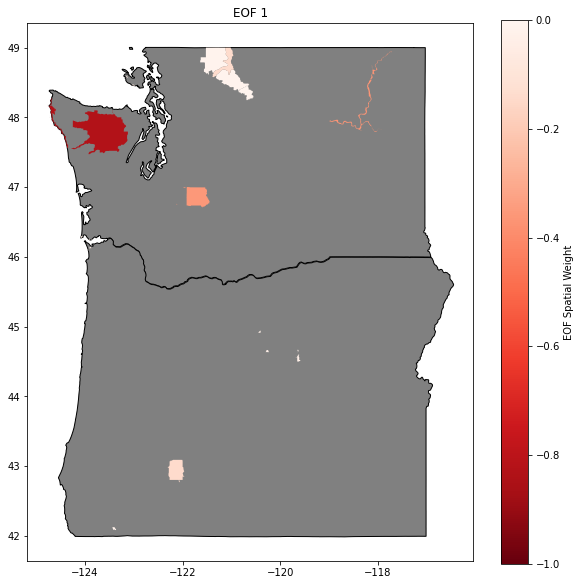

In [132]:
fig, ax = plt.subplots(figsize=(10,10))

wa_gdf.plot(ax=ax, facecolor='grey', edgecolor='k')
or_gdf.plot(ax=ax, facecolor='grey', edgecolor='k')
nat_park_gdf.plot(V[0,:], ax=ax, legend=True, vmin=-1, vmax=0, cmap='Reds_r', legend_kwds={'label':'EOF Spatial Weight'})
ax.set_title('EOF 1')

Text(0.5, 1.0, 'EOF 2')

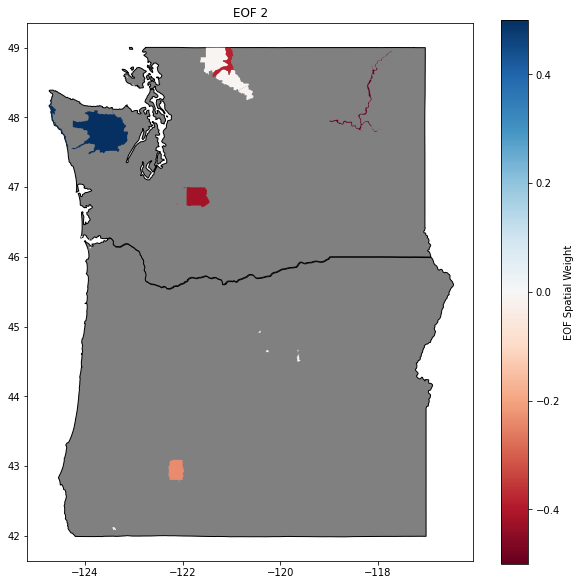

In [126]:
fig, ax = plt.subplots(figsize=(10,10))

wa_gdf.plot(ax=ax, facecolor='grey', edgecolor='k')
or_gdf.plot(ax=ax, facecolor='grey', edgecolor='k')
nat_park_gdf.plot(V[1,:], ax=ax, legend=True, vmin=-0.5, vmax=0.5, cmap='RdBu', legend_kwds={'label':'EOF Spatial Weight'})
ax.set_title('EOF 2')

Text(0.5, 1.0, 'EOF 3')

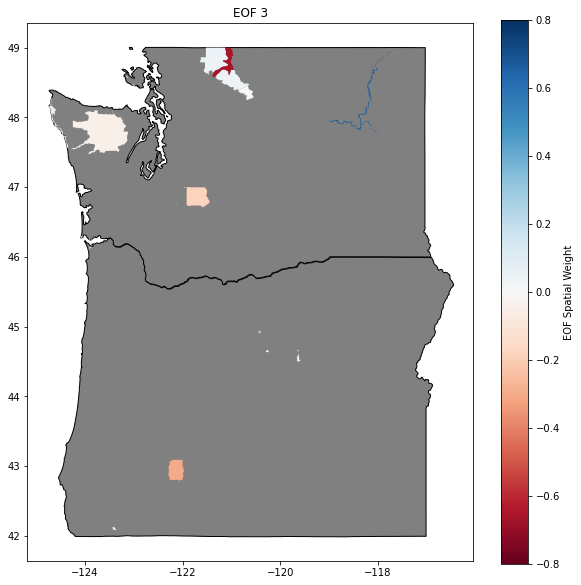

In [128]:
fig, ax = plt.subplots(figsize=(10,10))

wa_gdf.plot(ax=ax, facecolor='grey', edgecolor='k')
or_gdf.plot(ax=ax, facecolor='grey', edgecolor='k')
nat_park_gdf.plot(V[2,:], ax=ax, legend=True, vmin=-0.8, vmax=0.8, cmap='RdBu', legend_kwds={'label':'EOF Spatial Weight'})
ax.set_title('EOF 3')

Text(0.5, 1.0, 'EOF 4')

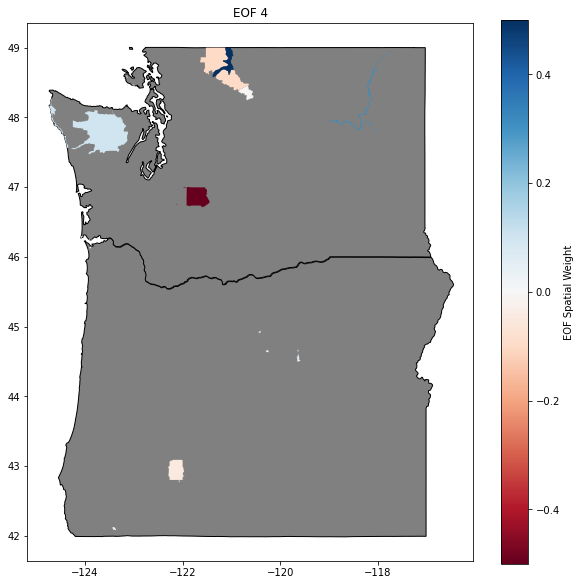

In [130]:
fig, ax = plt.subplots(figsize=(10,10))

wa_gdf.plot(ax=ax, facecolor='grey', edgecolor='k')
or_gdf.plot(ax=ax, facecolor='grey', edgecolor='k')
nat_park_gdf.plot(V[3,:], ax=ax, legend=True, vmin=-0.5, vmax=0.5, cmap='RdBu', legend_kwds={'label':'EOF Spatial Weight'})
ax.set_title('EOF 4')

Well I do not know how to interpret these.

Think I will ignore the spatial ones ... but perhaps use the temporal ones as a way of filtering out noise?